# Inspecting transfusion.data file
A pictogram of a blood bag with blood donation written in it

Blood transfusion saves lives - from replacing lost blood during major surgery or a serious injury to treating various illnesses and blood disorders. Ensuring that there's enough blood in supply whenever needed is a serious challenge for the health professionals. According to WebMD, "about 5 million Americans need a blood transfusion every year".

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive. We want to predict whether or not a donor will give blood the next time the vehicle comes to campus.

The data is stored in datasets/transfusion.data and it is structured according to RFMTC marketing model (a variation of RFM). We'll explore what that means later in this notebook. First, let's inspect the data.

In [1]:
# Print out the first 5 lines from the transfusion.data file
!head -5 data/transfusion.data

In [3]:
import pandas as pd
import numpy as np

# read the dataset (CSV formatted)
transfusion = pd.read_csv('data/transfusion.data')
transfusion.head()

,Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),whether he/she donated blood in March 2007
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


# Inspecting transfusion DataFrame

Model the data using a RFM evaluation for each donor. RFM stands for recency, frequency, monetary - a common marketing evaluation of customers. Customers in this instance are blood donors.
RFMTC is a variation of the RFM model. Below is a description of what each column means in our dataset:

* R (Recency - months since the last donation)
* F (Frequency - total number of donation)
* M (Monetary - total blood donated in c.c.)
* T (Time - months since the first donation)
 - a binary variable representing whether he/she donated blood in March 2007 (1 stands for donating blood; 0 stands for not donating blood)

It looks like every column in our DataFrame has the numeric type, which is exactly what we want when building a machine learning model. Let's verify our hypothesis.


In [3]:
 # summarize the data set
transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Recency (months)                            748 non-null    int64
 1   Frequency (times)                           748 non-null    int64
 2   Monetary (c.c. blood)                       748 non-null    int64
 3   Time (months)                               748 non-null    int64
 4   whether he/she donated blood in March 2007  748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


# Create a target
This notebook aims to predict if a donor will give blood. We can use column 4 ('whether he/she donated blood in March 2007') as the target column. 

In [4]:
# rename the target column
transfusion.rename(columns={'whether he/she donated blood in March 2007': 'Target'}, inplace=True)
transfusion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Recency (months)       748 non-null    int64
 1   Frequency (times)      748 non-null    int64
 2   Monetary (c.c. blood)  748 non-null    int64
 3   Time (months)          748 non-null    int64
 4   Target                 748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB


# Checking target incidence
Let's predict whether or not the same donor will give blood the next time the vehicle comes to campus. The model for this is a binary classifier, meaning that there are only 2 possible outcomes:

* 0 - the donor will not give blood
* 1 - the donor will give blood

Target incidence is defined as the number of cases of each individual target value in a dataset. That is, how many 0s in the target column compared to how many 1s? Target incidence gives us an idea of how balanced (or imbalanced) is our dataset.

In [5]:
# target incidence proportions

def incidence_rate(df):
    '''
        returns: incidence[0], incidence[1] 
    '''
    return round(df.query('Target == 0').count().Target/len(df.Target), 3), round(df.query('Target == 1').count().Target/len(df.Target), 3) 


no_donation, donation = incidence_rate(transfusion) 
print("Followup donations: ", donation) 
print("One off donations: ", no_donation)

Followup donations:  0.238
One off donations:  0.762


It is not unexpected to see that one-off donations were three times more than for repeat donations.

# Splitting transfusion into train and test datasets
Using SciKit Learn's train_test_split() method to split transfusion DataFrame.

Target incidence informed us that in our dataset 0s appear 76% of the time. We want to keep the same structure in train and test datasets, i.e., both datasets must have 0 target incidence of 76%. This is achieved using the train_test_split() method from the scikit learn library - specifying the stratify parameter. In our case, we'll stratify on the target column.

In [5]:
from sklearn.model_selection import train_test_split

X = transfusion.drop(columns=['Target'])
y = transfusion['Target']
# Split transfusion DataFrame into
# X_train, X_test, y_train and y_test datasets,
# stratifying on the `target` column
X_tpot_train, X_tpot_test, y_tpot_train, y_tpot_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

# Selecting the model using TPOT
TPOT is a Python Automated Machine Learning tool that optimizes machine learning pipelines using genetic programming.

TPOT Machine Learning Pipeline

TPOT will automatically explore hundreds of possible pipelines to find the best one for our dataset. Note, the outcome of this search will be a scikit-learn pipeline, meaning it will include any pre-processing steps as well as the model.

We are using TPOT to help us zero in on one model that we can then explore and optimize further.

In [7]:
from tpot import TPOTClassifier

tpot = TPOTClassifier(
        generations=20,
        population_size=300,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42,
        config_dict='TPOT light'
)

tpot.fit(X_tpot_train, y_tpot_train)

TPOTClassifier(config_dict='TPOT light', generations=20, n_jobs=-1,
               population_size=300, random_state=42, scoring='roc_auc')

In [11]:
# Area Under Curve score for tpot model
from sklearn.metrics import roc_auc_score
tpot_auc_score = roc_auc_score(y_tpot_test, tpot.predict_proba(X_tpot_test)[:, -1])
print(f'\nAUC score: {tpot_auc_score}')

NameError: name 'tpot' is not defined

In [9]:
# Best pipeline steps
print('\nBest pipeline steps: ', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    print(f'{idx}. {transform}')


Best pipeline steps: 
1. MinMaxScaler()
2. ZeroCount()
3. StackingEstimator(estimator=MultinomialNB(alpha=10.0))
4. MaxAbsScaler()
5. LogisticRegression(C=15.0, random_state=42)


# Manual model selection
## Data preprocessing


In [6]:
from sklearn.preprocessing import StandardScaler

# normalize the data
scaler = StandardScaler()
X_norm = scaler.fit_transform(transfusion.drop(columns=['Target']))

# split test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_norm,
                                                    y, 
                                                    test_size=0.25, 
                                                    stratify=y, 
                                                    random_state=42)

In [7]:
y_train.shape

(561,)

# Selecting model using a range of methods
## feature importance

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


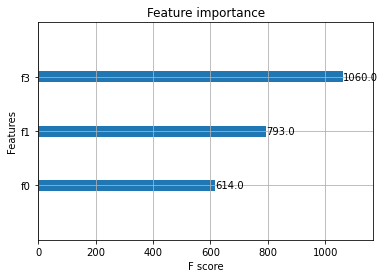

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import plot_importance, XGBClassifier

model = XGBClassifier(n_estimators=150, learning_rate=0.1)
model.fit(X_train, y_train)
plot_importance(model)
print(model)

## Decision tree

In [9]:
# decision tree
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=5, criterion='entropy')
tree_clf.fit(X_train, y_train)

# score the model against test data set
tree_clf_score = tree_clf.score(X_test, y_test)
print(f'Decision tree classifier accuracy: {tree_clf_score}')

Decision tree classifier accuracy: 0.7486631016042781


In [12]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_conf_matrix(cm, classes, title, normalize=False):
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# create confusion matrix
y_predicted_train = tree_clf.predict(X_train)
cm_train = confusion_matrix(y_train, y_predicted_train)
auc_train = roc_auc_score(y_train, y_predicted_train)

y_predicted_test = tree_clf.predict(X_test)
cm_test = confusion_matrix(y_test, y_predicted_test)
auc_train = roc_auc_score(y_test, y_predicted_test)

cm_train

array([[383,  44],
       [ 65,  69]])

NameError: name 'itertools' is not defined

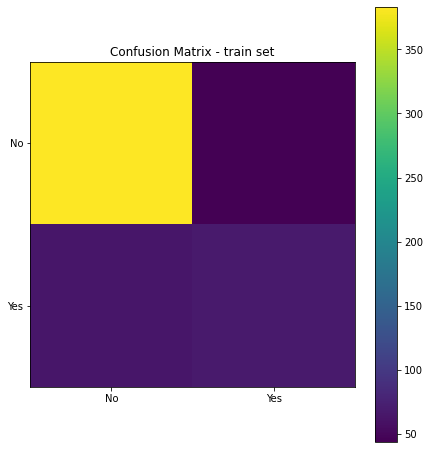

In [13]:
# plot confusion matrix
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_conf_matrix(cm_train, classes=['No', 'Yes'], title='Confusion Matrix - train set')

plt.subplot(1,2,2)
plot_conf_matrix(cm_test, classes=['No', 'Yes'], title='Confusion Matrix - test set')
plt.show()

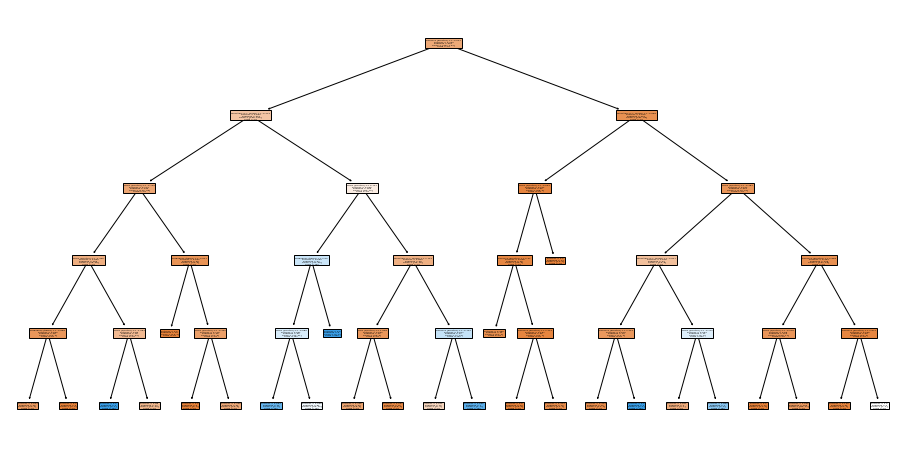

In [14]:
# plot decision tree
from sklearn.tree import plot_tree, export_graphviz

features = X.columns.values.tolist()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16,8))
plot_tree(tree_clf, feature_names=features, class_names=['No', 'Yes'], filled=True)
plt.show()
fig.savefig('BloodDonation.png')

In [15]:
import graphviz

graph_data = export_graphviz(tree_clf, feature_names=features, class_names=['No', 'Yes'], filled=True, out_file=None)
graph = graphviz.Source(graph_data)
graph.render("DecisionTree.dat")

'DecisionTree.dat.pdf'

## Random Forest

Evaluate a random forest classifier.

In [16]:
# create random forest classifier

rnd_f_clf = RandomForestClassifier(n_estimators=200, criterion='gini', n_jobs=-1, random_state=42)
rnd_f_clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [17]:
# get params for this classifier
rnd_f_clf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)>

In [18]:
# evaluate the features
X.info()
feat_importances = rnd_f_clf.feature_importances_
feat_importances

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Recency (months)       748 non-null    int64
 1   Frequency (times)      748 non-null    int64
 2   Monetary (c.c. blood)  748 non-null    int64
 3   Time (months)          748 non-null    int64
dtypes: int64(4)
memory usage: 23.5 KB


array([0.26261344, 0.15457416, 0.14797415, 0.43483825])

This tells us that Time (months) is the strongest feature.

In [26]:
# retrieve impurity-based feature importances
feature_names = [f'feature {i}' for i in range(X_train.shape[1])] 
rnd_f_clf_importances = pd.Series(feat_importances, index=feature_names)
rnd_f_clf_importances

feature 0    0.262613
feature 1    0.154574
feature 2    0.147974
feature 3    0.434838
dtype: float64

Text(0.5, 1.0, 'Feature importances using mean decrease in impurity')

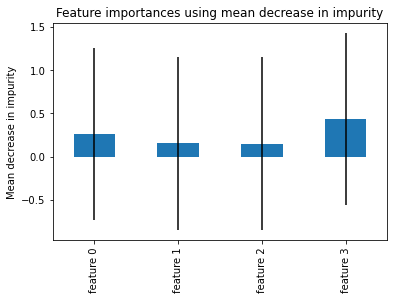

In [39]:
# plot impurity based feature importances
fig, ax = plt.subplots()
rnd_f_clf_importances.plot.bar(yerr=1, ax=ax)
ax.set_ylabel('Mean decrease in impurity')
plt.title('Feature importances using mean decrease in impurity')

In [40]:
# evaluate the model against test data
rnd_f_clf.score(X_test, y_test)

0.7219251336898396

In [41]:
from sklearn.metrics import RocCurveDisplay

rnd_f_clf_score = RocCurveDisplay(rnd_f_clf, X_test, y_test)
plt.show()

/home/daire/anaconda3/envs/spyder-env/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass fpr=RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42), tpr=[[-0.92789873 -0.08820401 -0.08820401 -0.75048336]
 [ 0.18458823 -0.60230736 -0.60230736 -0.38103151]
 [-0.68067941  0.42589934  0.42589934 -0.2578809 ]
 [-0.92789873  0.42589934  0.42589934  0.15262115]
 [-0.92789873 -0.77367514 -0.77367514 -1.32518623]
 [-0.68067941 -0.25957179 -0.25957179 -1.24308582]
 [ 0.55541721 -0.08820401 -0.08820401  1.63042853]
 [ 1.66790417 -0.60230736 -0.60230736  0.15262115]
 [-0.68067941  0.25453156  0.25453156  1.13782607]
 [-0.92789873 -0.08820401 -0.08820401 -0.75048336]
 [-0.68067941 -0.08820401 -0.08820401  1.63042853]
 [-0.68067941 -0.08820401 -0.08820401 -0.75048336]
 [-0.92789873 -0.77367514 -0.77367514 -1.32518623]
 [-0.92789873  0.9400027   0.9400027   1.83567955]
 [ 1.42068485 -0.60230736 -0.60230736 -0.54523233]
 [-0.92789873 -0.25957179 -0.25957179  

## Extra Trees Classifier

## Bagging

## Boosting